## 1. 必要依赖


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pytz
from scipy import stats
import os
import glob

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

def load_picarro_data(start_date, end_date, timezone):
    """加载 Picarro 数据"""
    data_path = r'Y:\公共空间\Data 数据 结果\监测仪数据\DataLog_User'
    
    all_data = []
    
    # 遍历时间范围内的日期
    current_date = start_date.date()
    end_date_obj = end_date.date()
    
    while current_date <= end_date_obj:
        year_folder = str(current_date.year).zfill(4)
        month_folder = str(current_date.month).zfill(2)
        day_folder = str(current_date.day).zfill(2)
        
        day_path = os.path.join(data_path, year_folder, month_folder, day_folder)
        
        if os.path.exists(day_path):
            dat_files = glob.glob(os.path.join(day_path, "*.dat"))
            
            for dat_file in dat_files:
                df = load_single_picarro_file(dat_file)
                if df is not None and not df.empty:
                    all_data.append(df)
        
        current_date += timedelta(days=1)
    
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        combined_df['DATETIME_DISPLAY'] = combined_df['DATETIME'].dt.tz_convert(timezone)
        return combined_df
    else:
        print("警告: 没有找到 Picarro 数据")
        return pd.DataFrame()

def load_pico_data(start_date, end_date, timezone):
    """加载 Pico 数据"""
    data_path = r'Y:\公共空间\Data 数据 结果\监测仪数据\MIRA_Data'
    
    all_data = []
    
    # 查找匹配的 .txt 文件
    all_txt_files = glob.glob(os.path.join(data_path, "*.txt"))
    
    for txt_file in all_txt_files:
        filename = os.path.basename(txt_file)
        # 排除不需要的文件
        if ('Eng.txt' in filename or 
            'spectralite.txt' in filename or 
            'config.txt' in filename):
            continue
        
        # 检查文件名是否符合 Pico 数据格式
        if filename.startswith('Pico') and filename.endswith('.txt'):
            try:
                name_part = filename.replace('Pico', '').replace('.txt', '')
                if '_' in name_part:
                    date_part = name_part.split('_')[1]  # 251106
                    year = int('20' + date_part[:2])
                    month = int(date_part[2:4])
                    day = int(date_part[4:6])
                    
                    file_date = datetime(year, month, day).date()
                    
                    # 检查日期是否在范围内
                    if start_date.date() <= file_date <= end_date.date():
                        df = load_single_pico_file(txt_file)
                        if df is not None and not df.empty:
                            all_data.append(df)
            except:
                continue
    
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        combined_df['DATETIME_DISPLAY'] = combined_df['DATETIME'].dt.tz_convert(timezone)
        return combined_df
    else:
        print("警告: 没有找到 Pico 数据")
        return pd.DataFrame()

def load_single_picarro_file(file_path):
    """加载单个 Picarro .dat 文件"""
    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            lines = f.readlines()
        
        header_line = None
        data_start = 0
        
        for i, line in enumerate(lines):
            if line.strip().startswith('DATE'):
                header_line = line.strip()
                data_start = i + 1
                break
        
        if header_line is None:
            return None
        
        headers = [h.strip() for h in header_line.split()]
        data_lines = []
        
        for line in lines[data_start:]:
            line = line.strip()
            if line:
                parts = line.split()
                if len(parts) >= len(headers):
                    data_lines.append(parts[:len(headers)])
        
        if not data_lines:
            return None
        
        df = pd.DataFrame(data_lines, columns=headers)
        
        # 转换数值列
        for col in ['CO2_dry', 'CH4_dry', 'H2O', 'CO2', 'CH4']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # 转换日期时间
        if 'DATE' in df.columns and 'TIME' in df.columns:
            df['DATETIME'] = pd.to_datetime(
                df['DATE'] + ' ' + df['TIME'].str.split('.').str[0], 
                format='%Y-%m-%d %H:%M:%S', 
                errors='coerce'
            )
            df['DATETIME'] = df['DATETIME'].dt.tz_localize('UTC')
        
        return df
    except Exception as e:
        return None

def load_single_pico_file(file_path):
    """加载单个 Pico .txt 文件"""
    try:
        df = pd.read_csv(file_path)
        
        # 重命名列
        column_mapping = {
            'Time Stamp': 'DATETIME',
            'CH4 (ppm)': 'CH4',
            'C2H6 (ppb)': 'C2H6',
            'H2O (ppm)': 'H2O',
            'Tgas(degC)': 'Tgas'
        }
        
        for old_col, new_col in column_mapping.items():
            if old_col in df.columns:
                df = df.rename(columns={old_col: new_col})
        
        # 转换数值列
        for col in ['CH4', 'C2H6', 'H2O', 'Tgas']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # 转换日期时间
        if 'DATETIME' in df.columns:
            df['DATETIME'] = pd.to_datetime(df['DATETIME'], format='%m/%d/%Y %H:%M:%S.%f', errors='coerce')
            df['DATETIME'] = df['DATETIME'].dt.tz_localize('Asia/Shanghai')
            df['DATETIME'] = df['DATETIME'].dt.tz_convert('UTC')
        
        return df
    except Exception as e:
        return None

def resample_data(df, time_window, method='median', max_cv=0.10):
    """对数据进行重采样，同时计算均值/中位数和标准差，并过滤高变异点"""
    if df.empty:
        return pd.DataFrame(), pd.DataFrame()
    
    # 选择需要的列
    cols_to_aggregate = [col for col in ['CH4_dry', 'CH4', 'H2O'] if col in df.columns]
    
    if not cols_to_aggregate:
        return pd.DataFrame(), pd.DataFrame()
    
    # 按时间窗口重采样
    grouped = df.set_index('DATETIME')[cols_to_aggregate].resample(time_window)
    
    # 计算中心值（均值或中位数）
    if method == 'mean':
        center_values = grouped.mean()
    else:  # median
        center_values = grouped.median()
    
    # 计算标准差
    std_values = grouped.std()
    
    # 计算变异系数 (CV = std / mean) 并过滤高变异点
    if method == 'mean':
        # 使用均值计算变异系数
        cv_values = std_values / center_values
    else:
        # 对于中位数，使用标准化四分位距或类似的变异系数
        # 这里我们仍使用 std / median 作为变异系数的近似
        cv_values = std_values / center_values
    
    # 创建掩码：变异系数小于等于最大允许值，且标准差和中心值都不为NaN
    valid_mask = (cv_values <= max_cv) & (std_values.notna()) & (center_values.notna())
    
    # 应用掩码，只保留低变异点
    center_values = center_values[valid_mask].dropna(axis=1, how='all')
    std_values = std_values[valid_mask].dropna(axis=1, how='all')
    
    # 确保两个 DataFrame 有相同的索引
    common_index = center_values.index.intersection(std_values.index)
    center_values = center_values.loc[common_index]
    std_values = std_values.loc[common_index]
    
    # 重置索引
    center_values = center_values.reset_index()
    std_values = std_values.reset_index()
    
    return center_values, std_values


## 2. 读取数据

In [2]:
print("开始分析 Picarro vs Pico 数据...")

# 设置时间范围
start_date = datetime(2025, 11, 13, 0, 0)
end_date = datetime(2025, 11, 16, 23, 59)

# 时区设置
timezone = pytz.timezone('Asia/Shanghai')

# 加载数据
print("正在加载 Picarro 数据...")
picarro_df = load_picarro_data(start_date, end_date, timezone)

print("正在加载 Pico 数据...")
pico_df = load_pico_data(start_date, end_date, timezone)


print(f"加载完成: Picarro数据 {len(picarro_df)} 条, Pico数据 {len(pico_df)} 条")



开始分析 Picarro vs Pico 数据...
正在加载 Picarro 数据...
正在加载 Pico 数据...
加载完成: Picarro数据 205043 条, Pico数据 348004 条


## 3. 单位统一
picarro的H2O单位是%，而pico的H2O单位是ppm，需要将pico的H2O列乘1e4进行缩放。


In [6]:
# picarro_df的H2O列乘1e4
picarro_df['H2O'] = picarro_df['H2O'] * 1e4


### 4. 定义函数

In [3]:
def correct_pico_data(picarro_data, pico_data, gas_type):
    """校正Pico数据，返回校正后的Pico数据"""
    # Align data by merging based on original column names
    merged_df = pd.merge(picarro_data[['DATETIME', 'CH4_dry', 'H2O']], 
                        pico_data[['DATETIME', 'CH4', 'H2O']], 
                        on='DATETIME', suffixes=('_picarro', '_pico'))
    
    # Remove NaN values and zero values
    merged_df = merged_df.dropna()
    
    if gas_type == 'CH4':
        x_col = 'CH4'      # Pico CH4 column
        y_col = 'CH4_dry'  # Picarro CH4 column
    else:  # H2O
        x_col = 'H2O_pico'     # Pico H2O column
        y_col = 'H2O_picarro'  # Picarro H2O column
    
    # Check if columns exist
    if x_col not in merged_df.columns or y_col not in merged_df.columns:
        print(f"警告: 数据中不存在列 {x_col} 或 {y_col}")
        print(f"可用列: {list(merged_df.columns)}")
        return None
    
    # Filter out zero values
    merged_df = merged_df[(merged_df[x_col] > 0) & (merged_df[y_col] > 0)]
    
    if merged_df.empty:
        print(f"警告: 没有足够的有效数据用于 {gas_type} 校正")
        return None
    
    # Prepare data
    x_data = merged_df[x_col].values
    y_data = merged_df[y_col].values
    
    # Calculate regression parameters
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
    
    # Apply correction: corrected_pico = slope * original_pico + intercept
    corrected_x_data = slope * x_data + intercept
    
    # Create a copy of the original Pico data and replace the specific column
    corrected_pico_data = pico_data.copy()
    
    # Update the corresponding column in the corrected Pico data
    if gas_type == 'CH4':
        corrected_pico_data.loc[corrected_pico_data.index.intersection(merged_df.index), 'CH4'] = corrected_x_data
    else:  # H2O
        corrected_pico_data.loc[corrected_pico_data.index.intersection(merged_df.index), 'H2O'] = corrected_x_data
    
    return corrected_pico_data


In [4]:
def create_comparison_plot(picarro_data, pico_data, picarro_std, pico_std, time_window, gas_type, plot_type="raw"):
    """创建比较散点图，包含误差线"""
    # Step 1: 合并原始数据（重命名列以规范化）
    # 重命名 Picarro 和 Pico 列，将 CH4_dry 列重命名为 CH4_picarro，H2O 列重命名为 H2O_picarro
    picarro_data_renamed = picarro_data.copy()
    picarro_data_renamed = picarro_data_renamed.rename(columns={
        'CH4_dry': 'CH4_dry_picarro',
        'H2O': 'H2O_picarro'
    })
    pico_data_renamed = pico_data.copy()
    pico_data_renamed = pico_data_renamed.rename(columns={
        'CH4': 'CH4_pico',
        'H2O': 'H2O_pico'
    })
    merged_df = pd.merge(picarro_data_renamed[['DATETIME', 'CH4_dry_picarro', 'H2O_picarro']], 
                        pico_data_renamed[['DATETIME', 'CH4_pico', 'H2O_pico']], 
                        on='DATETIME', suffixes=('_picarro', '_pico'))
    
    # Step 2: 合并 Picarro 标准差（需要重命名列以避免冲突）
    if not picarro_std.empty:
        # 重命名标准差列，使其与原始数据列名对应
        picarro_std_renamed = picarro_std.copy()
        picarro_std_renamed = picarro_std_renamed.rename(columns={
            'CH4_dry': 'CH4_dry_std',
            'H2O': 'H2O_std_picarro'
        })
        merged_df = pd.merge(merged_df, 
                           picarro_std_renamed[['DATETIME', 'CH4_dry_std', 'H2O_std_picarro']], 
                           on='DATETIME', how='left')
    
    # Step 3: 合并 Pico 标准差（需要重命名列以避免冲突）
    if not pico_std.empty:
        # 重命名标准差列，使其与原始数据列名对应
        pico_std_renamed = pico_std.copy()
        pico_std_renamed = pico_std_renamed.rename(columns={
            'CH4': 'CH4_std_pico',
            'H2O': 'H2O_std_pico'
        })
        merged_df = pd.merge(merged_df, 
                           pico_std_renamed[['DATETIME', 'CH4_std_pico', 'H2O_std_pico']], 
                           on='DATETIME', how='left')
    
    # Remove NaN values and zero values
    merged_df = merged_df.dropna()
    
    if gas_type == 'CH4':
        x_col = 'CH4_pico'      # Merged Pico CH4 column (横轴)
        y_col = 'CH4_dry_picarro'  # Merged Picarro CH4 column (纵轴)
        x_std_col = 'CH4_std_pico'
        y_std_col = 'CH4_dry_std'
        x_label = 'Pico CH$_4$ (ppm)'
        y_label = 'Picarro CH$_4$ (ppm)'
    else:  # H2O
        x_col = 'H2O_pico'     # Merged Pico H2O column (横轴)
        y_col = 'H2O_picarro'  # Merged Picarro H2O column (纵轴)
        x_std_col = 'H2O_std_pico'
        y_std_col = 'H2O_std_picarro'
        x_label = 'Pico H$_2$O (ppm)'
        y_label = 'Picarro H$_2$O (ppm)'
    
    # Check if columns exist
    if x_col not in merged_df.columns or y_col not in merged_df.columns:
        print(f"警告: 数据中不存在列 {x_col} 或 {y_col}")
        print(f"可用列: {list(merged_df.columns)}")
        return
    
    # Filter out zero values
    merged_df = merged_df[(merged_df[x_col] > 0) & (merged_df[y_col] > 0)]
    
    if merged_df.empty:
        print(f"警告: 没有足够的有效数据用于 {gas_type} 比较")
        return
    
    # Prepare data
    x_data = merged_df[x_col].values
    y_data = merged_df[y_col].values
    
    # Get error data if available
    x_errors = merged_df[x_std_col].values if x_std_col and x_std_col in merged_df.columns else None
    y_errors = merged_df[y_std_col].values if y_std_col and y_std_col in merged_df.columns else None
    
    # Calculate R²
    if len(x_data) < 2:  # 需要至少2个点才能计算回归
        print(f"警告: {gas_type} 数据点不足，无法进行回归分析")
        return
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
    r_squared = r_value ** 2
    
    # Calculate additional metrics
    differences = y_data - x_data  # Picarro - Pico
    me = np.mean(differences)  # Mean Error
    rmse = np.sqrt(np.mean(differences**2))  # Root Mean Square Error
    relative_error = np.mean(np.abs(differences) / x_data) * 100  # Relative Error (%)
    
    # Create fitted line
    fit_line = slope * x_data + intercept
    
    # Create scatter plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Set font to Arial
    plt.rcParams['font.family'] = 'Arial'
    
    # Format numbers to 4 significant digits when displaying
    x_data_formatted = [float(f"{val:.4g}") for val in x_data]
    y_data_formatted = [float(f"{val:.4g}") for val in y_data]
    
    # Use the formatted data for plotting
    x_data = np.array(x_data_formatted)
    y_data = np.array(y_data_formatted)
    
    # Handle error bars - ensure both x and y errors are arrays of same length as data
    if x_errors is not None:
        x_errors = np.array(x_errors)
        if len(x_errors) != len(x_data):
            # If lengths don't match, use the shorter one
            min_len = min(len(x_errors), len(x_data))
            x_errors = x_errors[:min_len]
            x_data = x_data[:min_len]
            y_data = y_data[:min_len]
            if y_errors is not None:
                y_errors = np.array(y_errors)[:min_len]
    
    if y_errors is not None:
        y_errors = np.array(y_errors)
        if len(y_errors) != len(y_data):
            # If lengths don't match, use the shorter one
            min_len = min(len(y_errors), len(y_data))
            y_errors = y_errors[:min_len]
            x_data = x_data[:min_len]
            y_data = y_data[:min_len]
            if x_errors is not None:
                x_errors = np.array(x_errors)[:min_len]
    
    # Scatter plot with error bars
    if x_errors is not None and y_errors is not None:
        ax.errorbar(x_data, y_data, xerr=x_errors, yerr=y_errors, 
                   fmt='o', alpha=0.6, markersize=5, capsize=3, 
                   elinewidth=1, markeredgewidth=1, 
                   label='Data Points with Error Bars')
    elif x_errors is not None:
        ax.errorbar(x_data, y_data, xerr=x_errors, fmt='o', alpha=0.6, 
                   markersize=5, capsize=3, elinewidth=1, markeredgewidth=1, 
                   label='Data Points with X Error Bars')
    elif y_errors is not None:
        ax.errorbar(x_data, y_data, yerr=y_errors, fmt='o', alpha=0.6, 
                   markersize=5, capsize=3, elinewidth=1, markeredgewidth=1, 
                   label='Data Points with Y Error Bars')
    else:
        ax.scatter(x_data, y_data, alpha=0.6, s=20, label='Data Points')
    
    # Determine axis limits for square plot
    min_val = min(x_data.min(), y_data.min())
    max_val = max(x_data.max(), y_data.max())
    # Add some padding
    padding = (max_val - min_val) * 0.05
    min_val -= padding
    max_val += padding
    
    # Make axes square with proper limits
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.set_aspect('equal', adjustable='box')
    
    # 1:1 line
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='1:1 Line', linewidth=2)
    
    # Fitted line
    ax.plot(x_data, fit_line, 'g-', label=f'Fitted Line (y = {slope:.4g}x + {intercept:.4g})', linewidth=2)
    
    ax.set_xlabel(x_label, fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)
    plot_type_name = "Raw" if plot_type == "raw" else "Corrected"
    ax.set_title(f'{gas_type} Concentration Comparison ({plot_type_name}) (Time Window: {time_window})', fontsize=18)
    ax.legend(fontsize=14)
    ax.grid(True, alpha=0.3)
    
    # Add statistics text without background, formatted to 4 significant digits
    stats_text = (f'Sample Size: {len(x_data)}\n'
                  f'R$^2$: {r_squared:.4g}\n'
                  f'a: {slope:.4g}\n'
                  f'b: {intercept:.4g}\n'
                  f'ME: {me:.4g}\n'
                  f'RMSE: {rmse:.4g}\n'
                  f'Relative Error: {relative_error:.4g}%')
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', edgecolor='none', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(f'{gas_type}_comparison_{time_window}_{plot_type}.png', dpi=300, bbox_inches='tight')
    plt.show()

#### 密度散点图

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import matplotlib
# 如果你的系统需要，可以设置中文字体
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['font.family'] = 'Arial' # 设置默认字体为 Arial
plt.rcParams['axes.unicode_minus'] = False # 解决负号'-'显示为方块的问题

def create_comparison_plot_density(picarro_data, pico_data, picarro_std, pico_std, time_window, gas_type, plot_type="raw", colormap='viridis'):
    """
    创建密度附色的比较散点图，颜色表示点的密度，可选包含误差线（目前误差线功能复杂，此处主要展示密度颜色）。
    新增参数:
        colormap (str): 用于密度颜色映射的colormap名称，例如 'viridis', 'plasma', 'inferno', 'magma', 'Blues' 等。
    """
    # --- 数据合并与处理部分保持不变 ---
    picarro_data_renamed = picarro_data.copy()
    picarro_data_renamed = picarro_data_renamed.rename(columns={
        'CH4_dry': 'CH4_dry_picarro',
        'H2O': 'H2O_picarro'
    })
    pico_data_renamed = pico_data.copy()
    pico_data_renamed = pico_data_renamed.rename(columns={
        'CH4': 'CH4_pico',
        'H2O': 'H2O_pico'
    })
    merged_df = pd.merge(picarro_data_renamed[['DATETIME', 'CH4_dry_picarro', 'H2O_picarro']], 
                         pico_data_renamed[['DATETIME', 'CH4_pico', 'H2O_pico']], 
                         on='DATETIME', suffixes=('_picarro', '_pico'))
    
    if not picarro_std.empty:
        picarro_std_renamed = picarro_std.copy()
        picarro_std_renamed = picarro_std_renamed.rename(columns={
            'CH4_dry': 'CH4_dry_std',
            'H2O': 'H2O_std_picarro'
        })
        merged_df = pd.merge(merged_df, 
                           picarro_std_renamed[['DATETIME', 'CH4_dry_std', 'H2O_std_picarro']], 
                           on='DATETIME', how='left')
    
    if not pico_std.empty:
        pico_std_renamed = pico_std.copy()
        pico_std_renamed = pico_std_renamed.rename(columns={
            'CH4': 'CH4_std_pico',
            'H2O': 'H2O_std_pico'
        })
        merged_df = pd.merge(merged_df, 
                           pico_std_renamed[['DATETIME', 'CH4_std_pico', 'H2O_std_pico']], 
                           on='DATETIME', how='left')
    
    merged_df = merged_df.dropna()
    
    if gas_type == 'CH4':
        x_col = 'CH4_pico'
        y_col = 'CH4_dry_picarro'
        x_std_col = 'CH4_std_pico'
        y_std_col = 'CH4_dry_std'
        x_label = 'Pico CH$_4$ (ppm)'
        y_label = 'Picarro CH$_4$ (ppm)'
    else:  # H2O
        x_col = 'H2O_pico'
        y_col = 'H2O_picarro'
        x_std_col = 'H2O_std_pico'
        y_std_col = 'H2O_std_picarro'
        x_label = 'Pico H$_2$O (ppm)'
        y_label = 'Picarro H$_2$O (ppm)'
    
    if x_col not in merged_df.columns or y_col not in merged_df.columns:
        print(f"警告: 数据中不存在列 {x_col} 或 {y_col}")
        print(f"可用列: {list(merged_df.columns)}")
        return
    
    merged_df = merged_df[(merged_df[x_col] > 0) & (merged_df[y_col] > 0)]
    
    if merged_df.empty:
        print(f"警告: 没有足够的有效数据用于 {gas_type} 比较")
        return
    
    x_data = merged_df[x_col].values
    y_data = merged_df[y_col].values
    
    # 检查是否有足够的点进行回归分析
    if len(x_data) < 2:
        print(f"警告: {gas_type} 数据点不足，无法进行回归分析")
        return

    # --- 计算密度 ---
    # 将 x 和 y 数据组合成一个二维数组
    xy_data = np.vstack([x_data, y_data])
    # 使用高斯核密度估计 (KDE) 计算每个点的密度
    kde = gaussian_kde(xy_data)
    # 计算每个原始数据点的密度值
    density_values = kde(xy_data)
    # 对密度值进行排序，以便后续按密度顺序绘制点，高密度点在上层
    idx_sorted = np.argsort(density_values)
    x_sorted = x_data[idx_sorted]
    y_sorted = y_data[idx_sorted]
    density_sorted = density_values[idx_sorted]

    # --- 回归分析与指标计算 ---
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
    r_squared = r_value ** 2
    differences = y_data - x_data
    me = np.mean(differences)
    rmse = np.sqrt(np.mean(differences**2))
    relative_error = np.mean(np.abs(differences) / (x_data + 1e-10)) * 100 # 防止除零

    fit_line = slope * x_data + intercept

    # --- 创建密度附色散点图 ---
    fig, ax = plt.subplots(figsize=(10, 8))

    # 使用 scatter 绘制密度图，颜色由 density_sorted 决定
    scatter = ax.scatter(x_sorted, y_sorted, c=density_sorted, cmap=colormap, alpha=0.6, s=20, edgecolors='none')
    
    # 添加颜色条
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Density', rotation=270, labelpad=20, fontsize=14)

    # 确定轴范围并设置为方形
    min_val = min(x_data.min(), y_data.min())
    max_val = max(x_data.max(), y_data.max())
    padding = (max_val - min_val) * 0.05
    min_val -= padding
    max_val += padding
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.set_aspect('equal', adjustable='box')

    # 绘制 1:1 线
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='1:1 Line', linewidth=2)

    # 绘制拟合线 (使用原始未排序的数据)
    ax.plot(x_data, fit_line, 'g-', label=f'Fitted Line (y = {slope:.4g}x + {intercept:.4g})', linewidth=2)

    ax.set_xlabel(x_label, fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)
    plot_type_name = "Raw" if plot_type == "raw" else "Corrected"
    ax.set_title(f'{gas_type} Concentration Comparison ({plot_type_name}) (Time Window: {time_window})', fontsize=18)
    ax.legend(fontsize=14)
    ax.grid(True, alpha=0.3)

    # 添加统计信息
    stats_text = (f'Sample Size: {len(x_data)}\n'
                  f'R$^2$: {r_squared:.4g}\n'
                  f'a: {slope:.4g}\n'
                  f'b: {intercept:.4g}\n'
                  f'ME: {me:.4g}\n'
                  f'RMSE: {rmse:.4g}\n'
                  f'Relative Error: {relative_error:.4g}%')
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', edgecolor='none', alpha=0.8))

    plt.tight_layout()
    plt.savefig(f'{gas_type}_density_comparison_{time_window}_{plot_type}.png', dpi=300, bbox_inches='tight')
    plt.show()

# --- 示例调用 ---
# 假设你有这些数据框
# picarro_data, pico_data, picarro_std, pico_std = ...
# time_window = "2023-10-01"
# gas_type = "CH4"
# plot_type = "raw"
# create_comparison_plot_density(picarro_data, pico_data, picarro_std, pico_std, time_window, gas_type, plot_type, colormap='viridis')

### 5. 主函数


处理时间窗口: 5s
重采样后数据点数量 - Picarro: 67433, Pico: 69134
  生成 CH4 原始比较图...


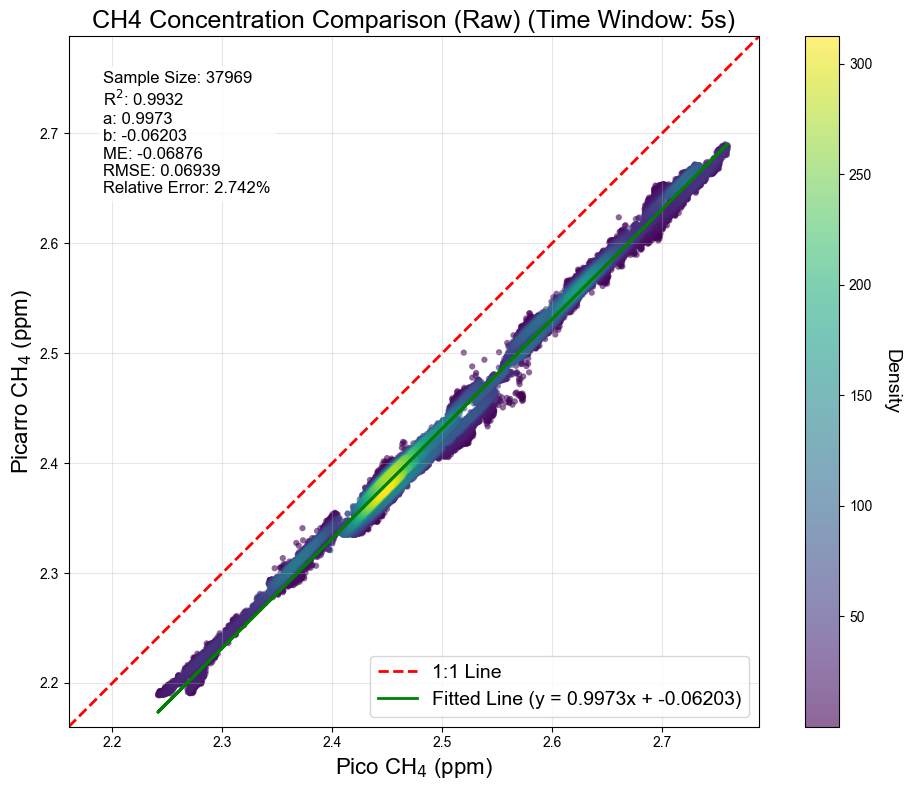

  校正 Pico CH4 数据...
  生成 CH4 校正比较图...


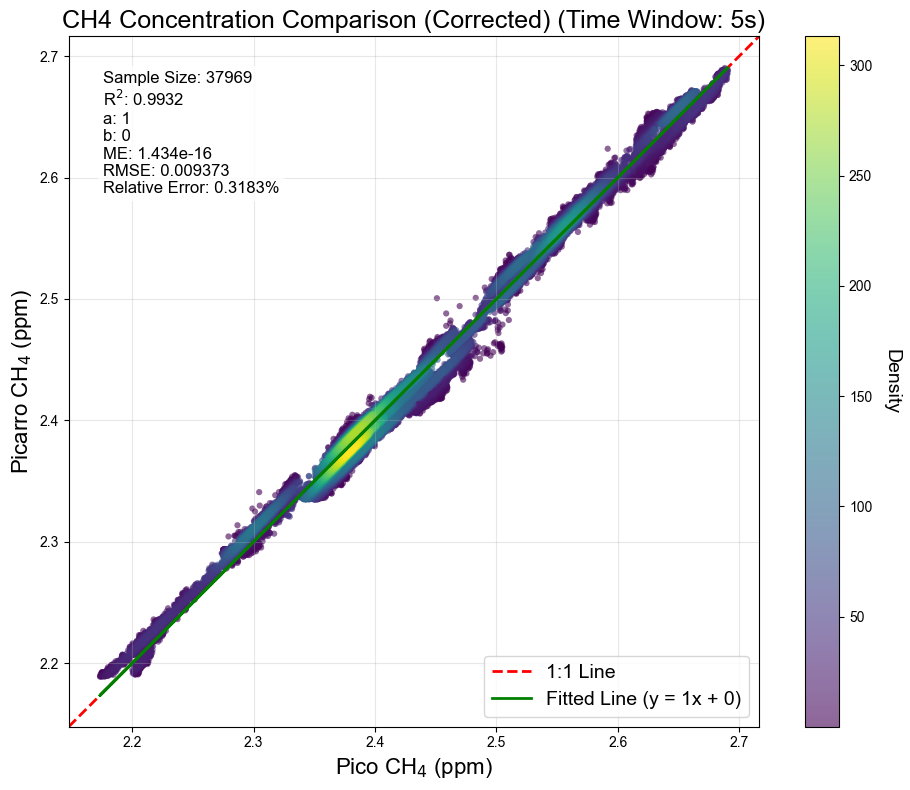

  生成 H2O 原始比较图...


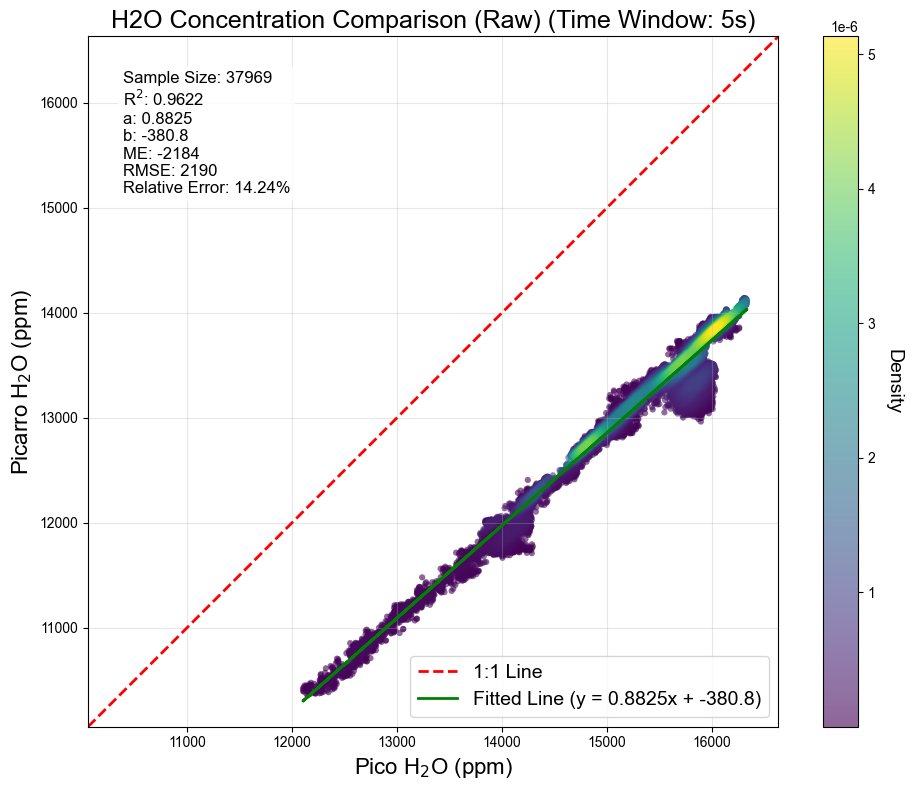

  校正 Pico H2O 数据...
  生成 H2O 校正比较图...


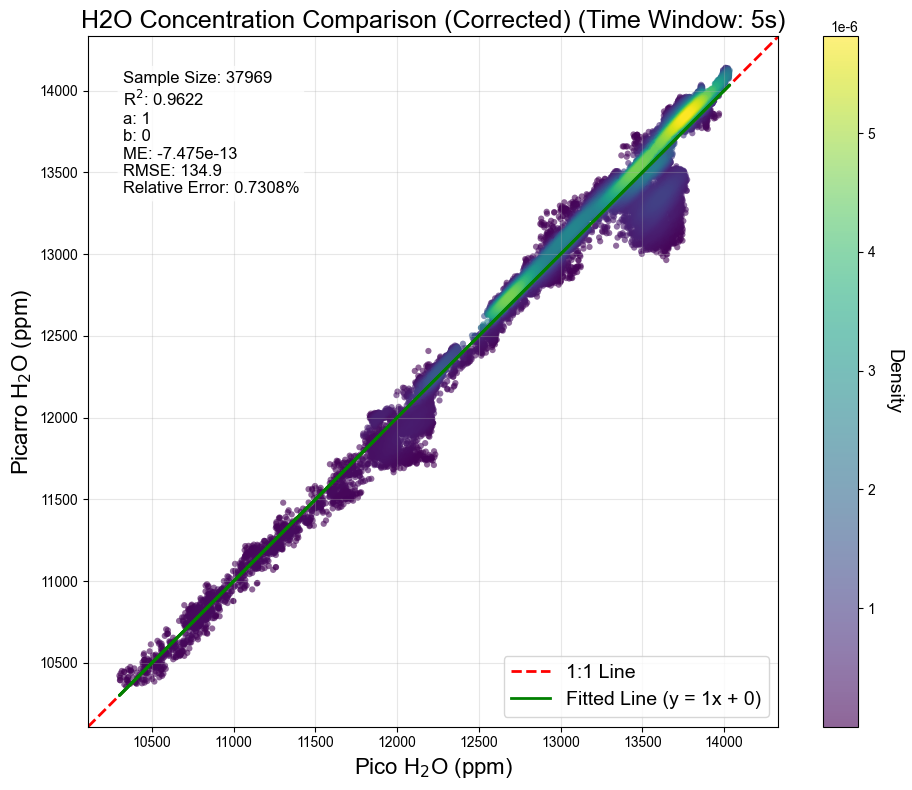

  时间窗口 5s 的分析完成


In [9]:
# 时间窗口选项
# window = '30min'
window = '5s'
print(f"\n处理时间窗口: {window}")

# Resample data with std, filtering points where CV > 10%
picarro_resampled, picarro_std = resample_data(picarro_df, window, method='median', max_cv=0.05)
pico_resampled, pico_std = resample_data(pico_df, window, method='median', max_cv=0.05)

print(f"重采样后数据点数量 - Picarro: {len(picarro_resampled)}, Pico: {len(pico_resampled)}")

# Generate CH4 raw comparison plot
print(f"  生成 CH4 原始比较图...")
# create_comparison_plot(picarro_resampled, pico_resampled, picarro_std, pico_std, window, 'CH4', plot_type="raw")
create_comparison_plot_density(picarro_resampled, pico_resampled, picarro_std, pico_std, window, 'CH4', plot_type="raw")

# Correct Pico data for CH4
print(f"  校正 Pico CH4 数据...")
corrected_pico_ch4 = correct_pico_data(picarro_resampled, pico_resampled, 'CH4')
if corrected_pico_ch4 is not None:
    # Generate CH4 corrected comparison plot
    print(f"  生成 CH4 校正比较图...")
    # create_comparison_plot(picarro_resampled, corrected_pico_ch4, picarro_std, pico_std, window, 'CH4', plot_type="corrected")
    create_comparison_plot_density(picarro_resampled, corrected_pico_ch4, picarro_std, pico_std, window, 'CH4', plot_type="corrected")

# Generate H2O raw comparison plot
print(f"  生成 H2O 原始比较图...")
# create_comparison_plot(picarro_resampled, pico_resampled, picarro_std, pico_std, window, 'H2O', plot_type="raw")
create_comparison_plot_density(picarro_resampled, pico_resampled, picarro_std, pico_std, window, 'H2O', plot_type="raw")

# Correct Pico data for H2O
print(f"  校正 Pico H2O 数据...")
corrected_pico_h2o = correct_pico_data(picarro_resampled, pico_resampled, 'H2O')
if corrected_pico_h2o is not None:
    # Generate H2O corrected comparison plot
    print(f"  生成 H2O 校正比较图...")
    # create_comparison_plot(picarro_resampled, corrected_pico_h2o, picarro_std, pico_std, window, 'H2O', plot_type="corrected")
    create_comparison_plot_density(picarro_resampled, corrected_pico_h2o, picarro_std, pico_std, window, 'H2O', plot_type="corrected")
        
print(f"  时间窗口 {window} 的分析完成")